# Minilab 6 - SF Taxi data

In this minilab we will begin to use [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to further look at trends in datasets. We will explore how we can use linear regression to make predictions of future 


The dataset is San Francisco Taxi data from 9/1/2012 to 9/17/2012. The dataset consists of 50,000 taxi trips taken in the Bay Area during that time period. For each trip we are given the departure time, arrival time, passenger fare, departure lat/lon coordinates, arrival lat/lon coordinates, departure taz and arrival taz. 

In [19]:
from datascience import *
import datetime
import matplotlib.pyplot as plt
import numpy as np
# from geopy.distance import great_circle
import warnings
warnings.filterwarnings("ignore")

In [64]:
# sf_taxi = Table.read_table('data/SF_Taxi.csv')
# sf_taxi = sf_taxi.relabeled('departure', 'departure time')
# sf_taxi = sf_taxi.relabeled('arrival', 'arrival time')
# sf_taxi = sf_taxi.relabeled('fare', 'fare ($)')
# sf_taxi = sf_taxi.relabeled('depx', 'dep lon')
# sf_taxi = sf_taxi.relabeled('depy', 'dep lat')
# sf_taxi = sf_taxi.relabeled('arrx', 'arr lon')
# sf_taxi = sf_taxi.relabeled('arry', 'arr lat')
# # sf_taxi = sf_taxi.drop(["dist","distcost"])
# # sf_taxi.to_csv('data/SF_taxi_data.csv')
# # sf_taxi = Table.read_table('data/SF_taxi_data.csv')
sf_taxi

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist,timecost,distcost,dist (miles)
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,0.0189403,0.0810616,0.0296035,1.26734
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,0.0285063,0.116872,0.0368681,1.85741
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.010899,0.00868171,0.00764047,0.683781
3,9/1/12 0:41,9/1/12 0:54,13.95,2,-122.419,37.8066,-122.415,37.7781,40,10,0.0287861,0.0862231,0.0308212,1.98227
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,0.0145844,0.0411753,0.0172304,0.878657
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.0221052,0.0422118,0.0175062,1.21328
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.00651272,0.0193946,0.00639047,0.422241
7,9/1/12 3:29,9/1/12 3:47,43.65,1,-122.403,37.7927,-122.386,37.6181,2,239,0.17544,0.556485,0.210315,12.1044
8,9/1/12 0:33,9/1/12 0:57,46.75,1,-122.387,37.6174,-122.407,37.7889,239,5,0.172696,0.53131,0.207095,11.9036
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.00968633,0.0334964,0.0102819,0.645616


## Step one - Adding meaningful columns to our data table
The data table is rich, but the inputs are not as useful as they could be. For example we have lat-lon coordinates for the origin and destination. We are probaly more interested in the expected travel time or travel distance in miles from the origin to the destination.

### Computing Great Circle Distance
The great circle distance calculates the shortest distance between two points on the surface of a sphere. The python package [geopy](https://pypi.python.org/pypi/geopy) has a method that computes the great circle distance between two lat,lon coordinates on the surface of a sphere. Below, I have used the [.apply](http://data8.org/datascience/_autosummary/datascience.tables.Table.apply.html#datascience.tables.Table.apply) method to calculate the great circle distance between my destination and arrival point. I have saved this in my table in a column called 'dist (miles)'



In [70]:
# sf_taxi['dist (miles)'] = sf_taxi.apply(lambda xlat, xlon, ylat, ylon: 
#                                         great_circle((xlat, xlon), (ylat, ylon)).miles, 
#                                         ["dep lat","dep lon","arr lat","arr lon"])

# sf_taxi['dist (miles)'] = sf_taxi.column('dist (miles)')*sf_taxi.column('distcost')/sf_taxi.column('dist')
# sf_taxi = sf_taxi.drop(["dist", "timecost", "distcost"])
sf_taxi.to_csv('data/SF_taxi_data.csv')

### Computing Trip Duration
We can write our own methods to help process the data. For example we can create a method to compute trip duration from the departure and arrival times. First we have to convert the departure time and arrival time into a timestamp, then we can compute the difference. Finally we convert it to minutes.

**Task 1** Use the .apply method to create a 'trip duration (min)' column in the sf_taxi table.


In [14]:
def get_dur(start,finish): 
    start_time = datetime.datetime.strptime(start, "%m/%d/%y %H:%M")
    end_time = datetime.datetime.strptime(finish, "%m/%d/%y %H:%M")
    return (end_time-start_time).seconds/60.

In [15]:
# Answer key
sf_taxi["duration (min)"] = sf_taxi.apply(lambda start, finish: get_dur(start, finish), ["departure time", "arrival time"])

## Scatter Plots of trip duration vs. distance

** Task 2** Create a scatter plot of travel time vs. distace. Make sure fit_line is enabled

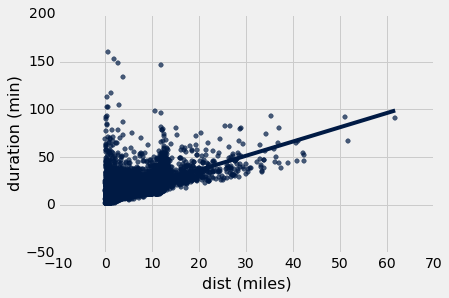

In [22]:
# Answer key
sf_taxi.select(["duration (min)", "dist (miles)"]).scatter("dist (miles)", fit_line=True)

### Making inferences
** Question 1** Use the linear regression result to predict the time to travel 25 miles in the bay area. Do you think this is a good prediction? Why or why not? 
What is the travel time for a 5 mile trip? What about a 35 mile trip? Do you think these are good predictions?


## Segmenting the data.
The best fit line above includes all 50,000 trips from a 2+ week period in 2012. The relationship between trip duration and distance traveled on a weekday may be different than that on a weekend, for example. In the cell below I have given you some helper functions that may be useful in sementing your data. 

** Task 3** Add a 'start hour' column and a 'day of week', column to the sf_taxi table using the helper functions below.

In [28]:
def get_hour(s): return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").hour
def get_date(s): return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date()
def get_weekday(s): return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date().weekday()
# 0 = Monday - 6= Sunday

def fit(x,y): return np.poly1d(np.polyfit(x,y,1))(x)

In [31]:
# Answer key
sf_taxi['start hour'] = sf_taxi.apply(get_hour, "departure time")
sf_taxi['date'] = sf_taxi.apply(get_date, "departure time")
sf_taxi['day of week'] = sf_taxi.apply(get_weekday, "departure time")


## Scatter plot of trip distance vs. duration. 
**Task 3** <li> Created a table that contains only weekend trips. Create another that contains only weekday trips.<li> Create a scatter plot of trip distance vs. duration. Plot weekend trips in blue and weekday trips in red.<li> Add a fit line to the graph - I created a helper function called fit() to help you with this - follow the format used in the weekend scatter plot below.<li> Make sure you plots have appropriate labels, tiltes and legends


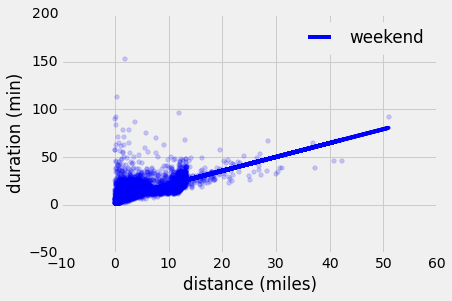

In [53]:
weekend = sf_taxi.where(sf_taxi.column('day of week')>=5)

x, y=  weekend.column("dist (miles)"), weekend.column("duration (min)")
plt.scatter(x,y,color='blue', alpha = .2)
plt.plot(x,fit(x,y), color='blue', label = 'weekend')

# Answer key
# x, y=  weekday.column("dist (miles)"), weekday.column("duration (min)")
# plt.scatter(x,y,color='blue', alpha = .2)
# plt.plot(x,fit(x,y), color='blue', label = 'weekend')

plt.xlabel('distance (miles)')
plt.ylabel('duration (min)')
plt.legend()

## Create a scatter plot of midday (11-2pm) weekday trips  vs. evening (5-8pm) weekday trips. 
Color evening trips in blue, midday trips in red. Add fit lines, label, and legends as above.

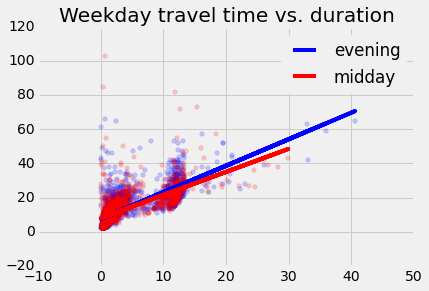

In [43]:

weekday_evening = weekday.where(np.logical_and(weekday.column('start hour')>17,weekday.column('start hour')<20))
weekday_midday = weekday.where(np.logical_and(weekday.column('start hour')>11,weekday.column('start hour')<14))

x, y=  weekday_evening.column("dist (miles)"), weekday_evening.column("duration (min)")
plt.scatter(x,y,color='blue', alpha = .2)
plt.plot(x,fit(x,y), color='blue', label = 'evening')

x, y=  weekday_midday.column("dist (miles)"), weekday_midday.column("duration (min)")
plt.scatter(x,y,color='red', alpha = .2)
plt.plot(x,fit(x,y), color='red', label = 'midday')

plt.title('Weekday travel time vs. duration')
plt.xlabel('distance (miles)')
plt.ylabel('duration (min)')
plt.legend()

**Question 2** What do you notice about the two trends - how does the midday travel time/mile compare to the evening travel time/mile.

**Question 3** Notice the two cluster of trips - one around 10 miles - the other at 1-5 miles. Why do you think these two clusters emerge.

## Find the TAZ with the most popular origin
**Task**
<li> Find the most popular taxi trip origin TAZ. <li> Create a scatter plot of all sf trips in grey. Overlay with a scatter plot of only trips that originate at the most popular TAZ.

**Question** What patterns do you notice? Do trips from the most popular TAZ look similar to trips in the rest of the area? Do you have a guess of what the most popular taxi origin might be?

In [60]:
# Answer key
taz_counts = sf_taxi.group("deptaz")
taz_counts.where("count", max(taz_counts["count"]))



deptaz,count
239,3696


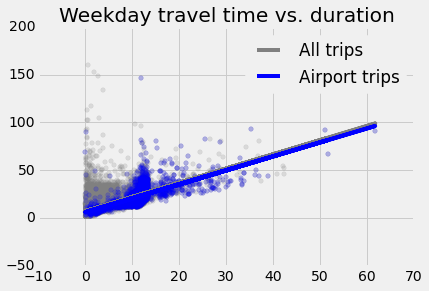

In [52]:
taz_239 = sf_taxi.where(sf_taxi.column("deptaz")==239)
x, y=  sf_taxi.column("dist (miles)"), sf_taxi.column("duration (min)")
plt.scatter(x,y,color='grey', alpha = .2)
plt.plot(x,fit(x,y), color='grey', label = 'All trips')

x, y=  taz_239.column("dist (miles)"), taz_239.column("duration (min)")
plt.scatter(x,y,color='blue', alpha = .2)
plt.plot(x,fit(x,y), color='blue', label = 'Airport trips')


plt.title('Weekday travel time vs. duration')
plt.xlabel('')
plt.legend()

In [87]:
sf_taxi.where(sf_taxi.column("timecost") == max(sf_taxi.column("timecost")))

# dept_239 = sf_taxi.where(sf_taxi.column("deptaz") == 239)

id,departure,arrival,fare,num,depx,depy,arrx,arry,deptaz,arrtaz,dist,timecost,distcost,hour,weekday,duration
28972,9/8/12 18:34,9/8/12 19:06,176.97,1,-122.392,37.6156,-121.953,37.3556,239,433,0.509817,3.72998,0.540282,18,5,0:32:00
